In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import shutil
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # change to chosen GPU to use, nothing if work on CPU

import numpy as np
import time
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd

from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import cartopy.crs as ccrs

In [3]:
import h5py
import matplotlib.patches as patches

In [4]:
from deepsphere import models, experiment_helper, plot, utils
from deepsphere.data import LabeledDatasetWithNoise, LabeledDataset
import hyperparameters

List of parameters:
* PRECT: Total (convective and large-scale) precipitation rate (liq + ice)
* PS: Surface pressure
* PSL: sea level pressure
* QREFHT: Reference height humidity
* T200: temp at 200 mbar pressure surface
* T500: temp at 500 mbar pressure surface
* TMQ: Total (vertically integrated) precipitatable water
* TS: Surface temperature (radiative)
* U850: Zonal wind at 850 mbar pressure surface
* UBOT: Lowest model level zonal wind
* V850: Meridional wind at 850 mbar pressure surface
* VBOT: Lowest model level meridional wind
* Z100: Geopotential Z at 100 mbar pressure surface
* Z200: Geopotential Z at 200 mbar pressure surface
* ZBOT: Lowest model level height

4 measures per day, 365 days a year
resolution of 768 x 1152 equirectangular grid (25-km at equator)

boxes:
* ymin
* xmin
* ymax
* xmax
* class:
    * 0: Tropical Depression
    * 1: Tropical Cyclone
    * 2: Extratropical Cyclone
    * 3: Atmospheric River

In [5]:
year = 2005
datapath = '../data/ExtremeWeather/climo_{}.h5'.format(year)

In [11]:
year, month, day, hour, run = 2106, 1, 1, 0, 1
years = np.arange(2106, 2115)
months = np.arange(1,13)
days = np.arange(1,32)
hours = np.arange(8)
runs = np.arange(7)
datapath = '../data/Climate/data-{}-{:0>2d}-{:0>2d}-{:0>2d}-{}.h5'.format(year, month, day, hour, run)

In [14]:
h5f = h5py.File(datapath)
images = h5f["images"] # (1460,16,768,1152) numpy array
boxes = h5f["boxes"] # (1460,15,5) numpy array

KeyError: "Unable to open object (object 'data' doesn't exist)"

In [19]:
# Features
# [TMQ, U850, V850, UBOT, VBOT, QREFHT, PS, PSL, T200, T500, PRECT, TS, TREFHT, Z1000, Z200, ZBOT]
data = h5f['climate']["data"]     # 16x768x1152  Features X lat X lon
labels = h5f['climate']["labels"] # 768x1152     lat X lon
stats = h5f['climate']["stats"]   # 16x4         Features x [mean, max, min, std]

In [20]:
lon_ = np.arange(1152)/1152*360
lat_ = np.arange(768)/768*180-90
lon, lat = np.meshgrid(lon_, lat_)

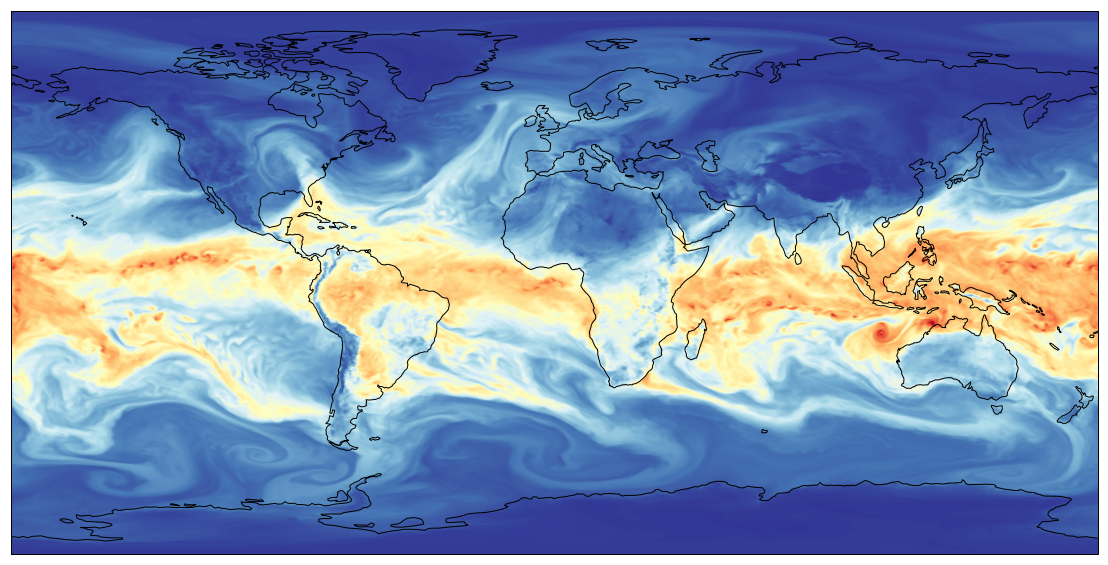

In [44]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.scatter(lon, lat, s=1,
            c=data[0,:,:], cmap=plt.get_cmap('RdYlBu_r'), alpha=1)

color = ['r', 'y', 'c', 'g']

# for i in range(15):
#     ymin, xmin, ymax, xmax, clas = boxes[0,i]
#     if ymin==-1:
#         print("no box")
#         continue
#     ymin, ymax = lat_[ymin], lat_[ymax]
#     xmin, xmax = lon_[xmin], lon_[xmax]
#     plt.scatter(np.array([xmin, xmin, xmax, xmax]),np.array([ymin, ymax, ymin, ymax]), c=color[clas])
#     rect = patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,linewidth=2,edgecolor=color[clas],facecolor='none')
#     ax.add_patch(rect)

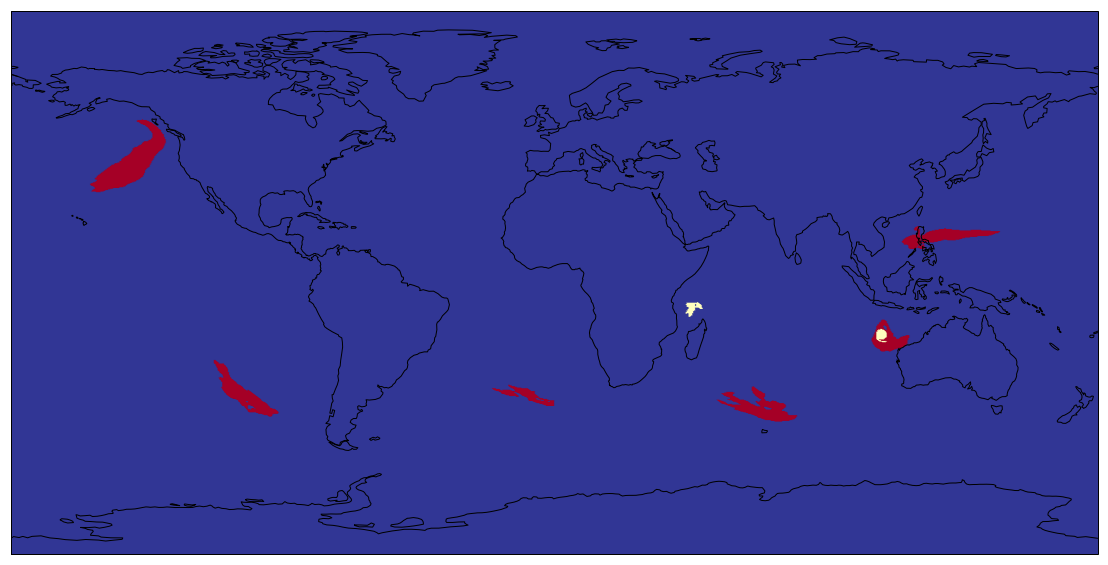

In [25]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.scatter(lon, lat, s=1,
            c=labels[:,:], cmap=plt.get_cmap('RdYlBu_r'), alpha=1)

color = ['r', 'y', 'c', 'g']

# for i in range(15):
#     ymin, xmin, ymax, xmax, clas = boxes[0,i]
#     if ymin==-1:
#         print("no box")
#         continue
#     ymin, ymax = lat_[ymin], lat_[ymax]
#     xmin, xmax = lon_[xmin], lon_[xmax]
#     plt.scatter(np.array([xmin, xmin, xmax, xmax]),np.array([ymin, ymax, ymin, ymax]), c=color[clas])
#     rect = patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,linewidth=2,edgecolor=color[clas],facecolor='none')
#     ax.add_patch(rect)

In [39]:
from scipy.interpolate import griddata, RectBivariateSpline, RegularGridInterpolator, LinearNDInterpolator, interp2d

In [40]:
from scipy.interpolate import griddata#, RectBivariateSpline, RegularGridInterpolator
Nside = 64
pix = np.arange(12*Nside**2)
coords_hp = hp.pix2ang(Nside, pix, nest=True, lonlat=True)
coords_hp = np.asarray(coords_hp).T
# lon_rad, lat_rad = np.deg2rad(lon), np.deg2rad(lat)
coords_map = hp.ang2vec(lon, lat, lonlat=True).reshape((-1, 3))
coords_map = np.stack([lon, lat], axis=-1).reshape((-1, 2))
# map_hp = griddata(coords_map, images[0,0].flatten(), coords_hp, 'linear')

In [41]:
t = time.time()
map_hp1 = griddata(coords_map, data[0].flatten(), coords_hp, 'linear')
print("time taken:", time.time()-t)

# t = time.time()
# map_hp2 = griddata(coords_map, images[0,0].flatten(), np.asarray(coords_hp).T, 'linear')
# print("time taken:", time.time()-t)

# t = time.time()
# f = interp2d(lon_, lat_, images[0,0])
# map_hp3 = np.diag(f(*coords_hp))  # False result???
# print("time taken:", time.time()-t)

t = time.time()
f = RegularGridInterpolator((lon_, lat_), data[0].T)
map_hp3 = f(coords_hp)
print("time taken:", time.time()-t)

time taken: 23.432502508163452
time taken: 0.01588726043701172


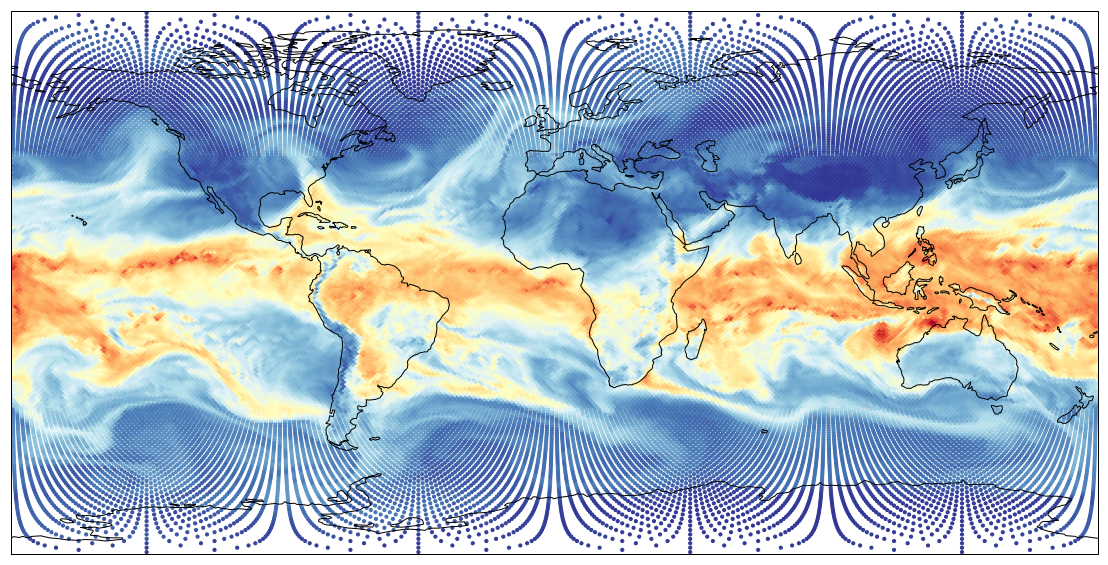

In [42]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.scatter(coords_hp[:,0], coords_hp[:,1], s=10,
            c=map_hp1, cmap=plt.get_cmap('RdYlBu_r'), alpha=1)

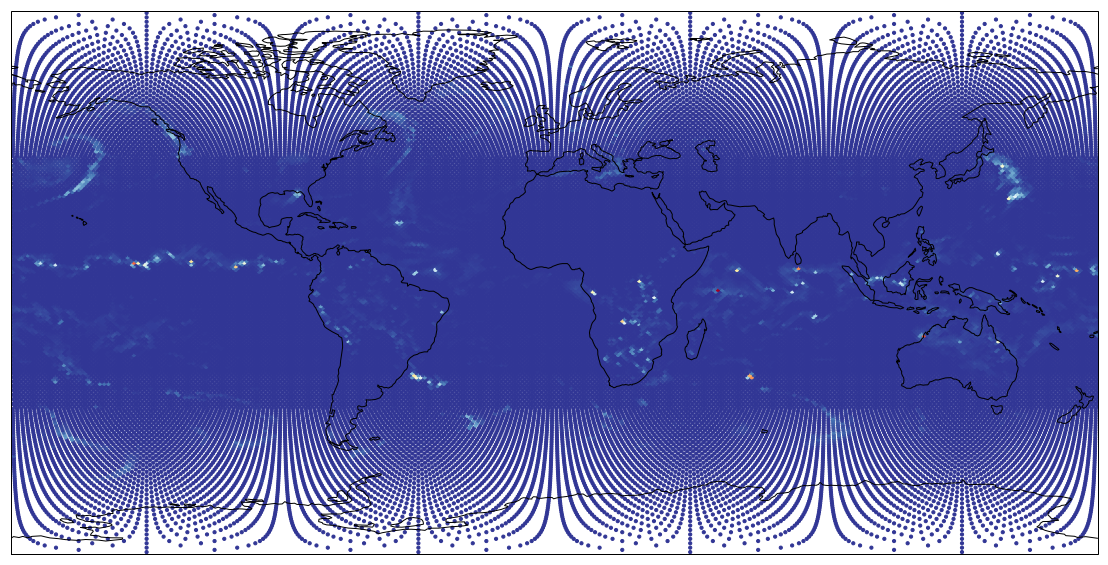

In [27]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.scatter(coords_hp[:,0], coords_hp[:,1], s=10,
            c=map_hp3, cmap=plt.get_cmap('RdYlBu_r'), alpha=1)
# indic = np.where(~np.isclose(map_hp1, map_hp3, atol=1e-6))
# plt.scatter(coords_hp[indic,0], coords_hp[indic,1], s=10,
#             c='r')

In [ ]:
data_path = '../data/ExtremeWeather/'
measures, channels, lat_x, lon_x = images.shape
nfeat = 5
Nside = [32, 64]
for nside in Nside:
    npix = hp.nside2npix(nside)
    data = np.empty((measures, npix, channels))
    labels = np.zeros((measures, npix))
    pix = np.arange(npix)
    coords_hp = hp.pix2ang(nside, pix, nest=True, lonlat=True)
    coords_hp = np.asarray(coords_hp).T
    for measure in tqdm(range(measures)):
        for channel in tqdm(range(channels)):
#             data[measure,:,channel] = griddata(coords_map, images[measure,channel].flatten(), coords_hp, 'linear')
            f = RegularGridInterpolator((lon_, lat_), images[measure,channel].T)
            data[measure,:,channel] = f(coords_hp)
        for box in range(boxes.shape[1]):
            ymin, xmin, ymax, xmax, clas = boxes[measure,box]
            if ymin==-1:
#                 print("no box")
                continue
            ymin, ymax = lat_[ymin%lat_x], lat_[ymax%lat_x]
            xmin, xmax = lon_[xmin%lon_x], lon_[xmax%lon_x]
            if xmax>xmin and ymax>ymin:
                indexes = np.where(np.logical_and(np.logical_and(coords_hp[:,0]>=xmin, coords_hp[:,0]<=xmax), 
                                        np.logical_and(coords_hp[:,1]>=ymin, coords_hp[:,1]<=ymax)))
            else:
                indexes = np.where(np.logical_and(np.logical_or(coords_hp[:,0]>=xmin, coords_hp[:,0]<=xmax), 
                                        np.logical_and(coords_hp[:,1]>=ymin, coords_hp[:,1]<=ymax)))
            labels[measure, indexes] = clas + 1
#             if xmax<=xmin or ymax<=ymin:
#                 print(xmin, ymin, xmax, ymax)
#                 print(labels[measure, indexes])
#                 fig = plt.figure(figsize=(25, 50))
#                 ax = fig.add_subplot(211)
#                 ax.scatter(coords_hp[:,0], coords_hp[:,1], 
#                            c=labels[measure,:], cmap=plt.get_cmap('RdYlBu_r'), alpha=1)
#                 ax2 = fig.add_subplot(212, projection=ccrs.PlateCarree())
#                 ax2.set_global()
#                 plt.scatter(coords_hp[:,0], coords_hp[:,1], s=10,
#                     c=labels[measure,:], cmap=plt.get_cmap('RdYlBu_r'), alpha=1)
#                 break
#         if (xmax<=xmin or ymax<=ymin) and ymin!=-1:
#             break
#     break
    file = data_path + 'EW_{}nside_{}'.format(nside, year)
    np.savez(file, data=data, labels=labels)

 19%|█▉        | 3/16 [00:04<00:17,  1.35s/it]

In [87]:
file = data_path + 'EW_{}nside_{}'.format(Nside, year)

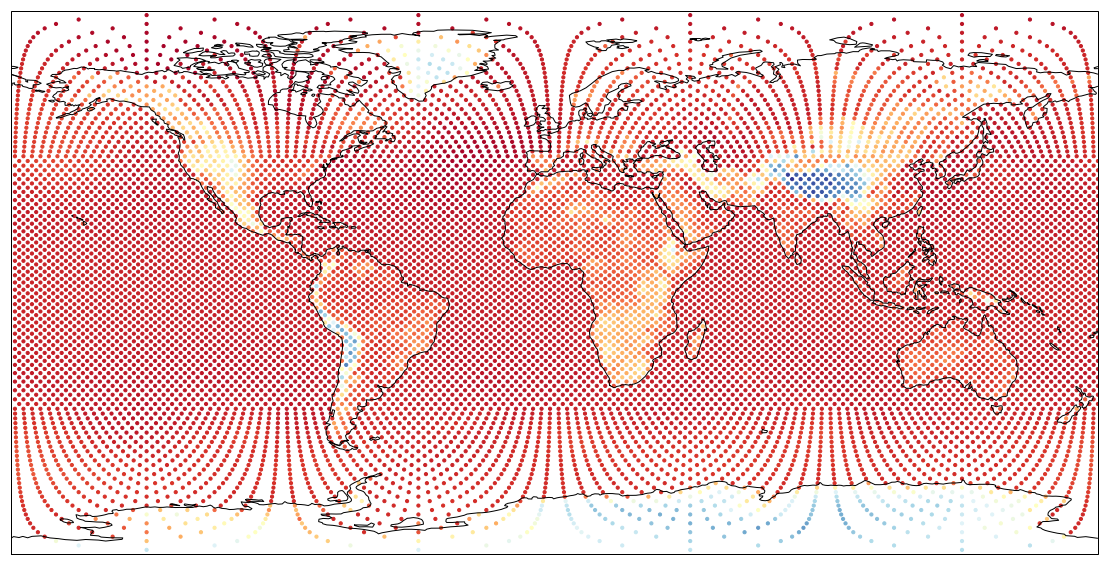

In [40]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.scatter(coords_hp[:,0], coords_hp[:,1], s=10,
            c=data[0,:,1], cmap=plt.get_cmap('RdYlBu_r'), alpha=1)

NameError: name 'coords_hp' is not defined

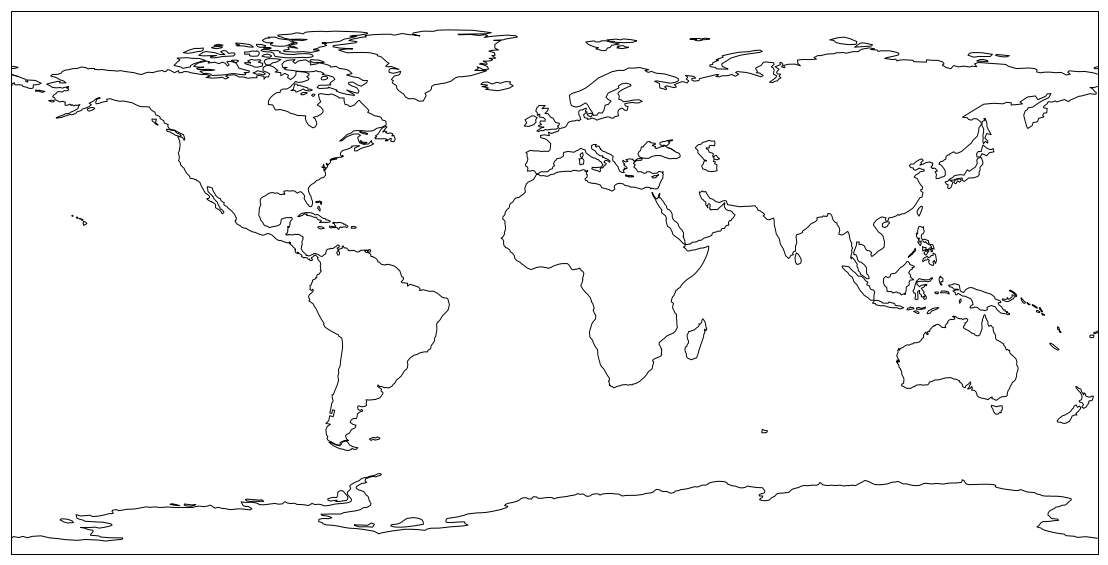

In [50]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.scatter(coords_hp[:,0], coords_hp[:,1], s=10,
            c=labels[0,:], cmap=plt.get_cmap('RdYlBu_r'), alpha=1)

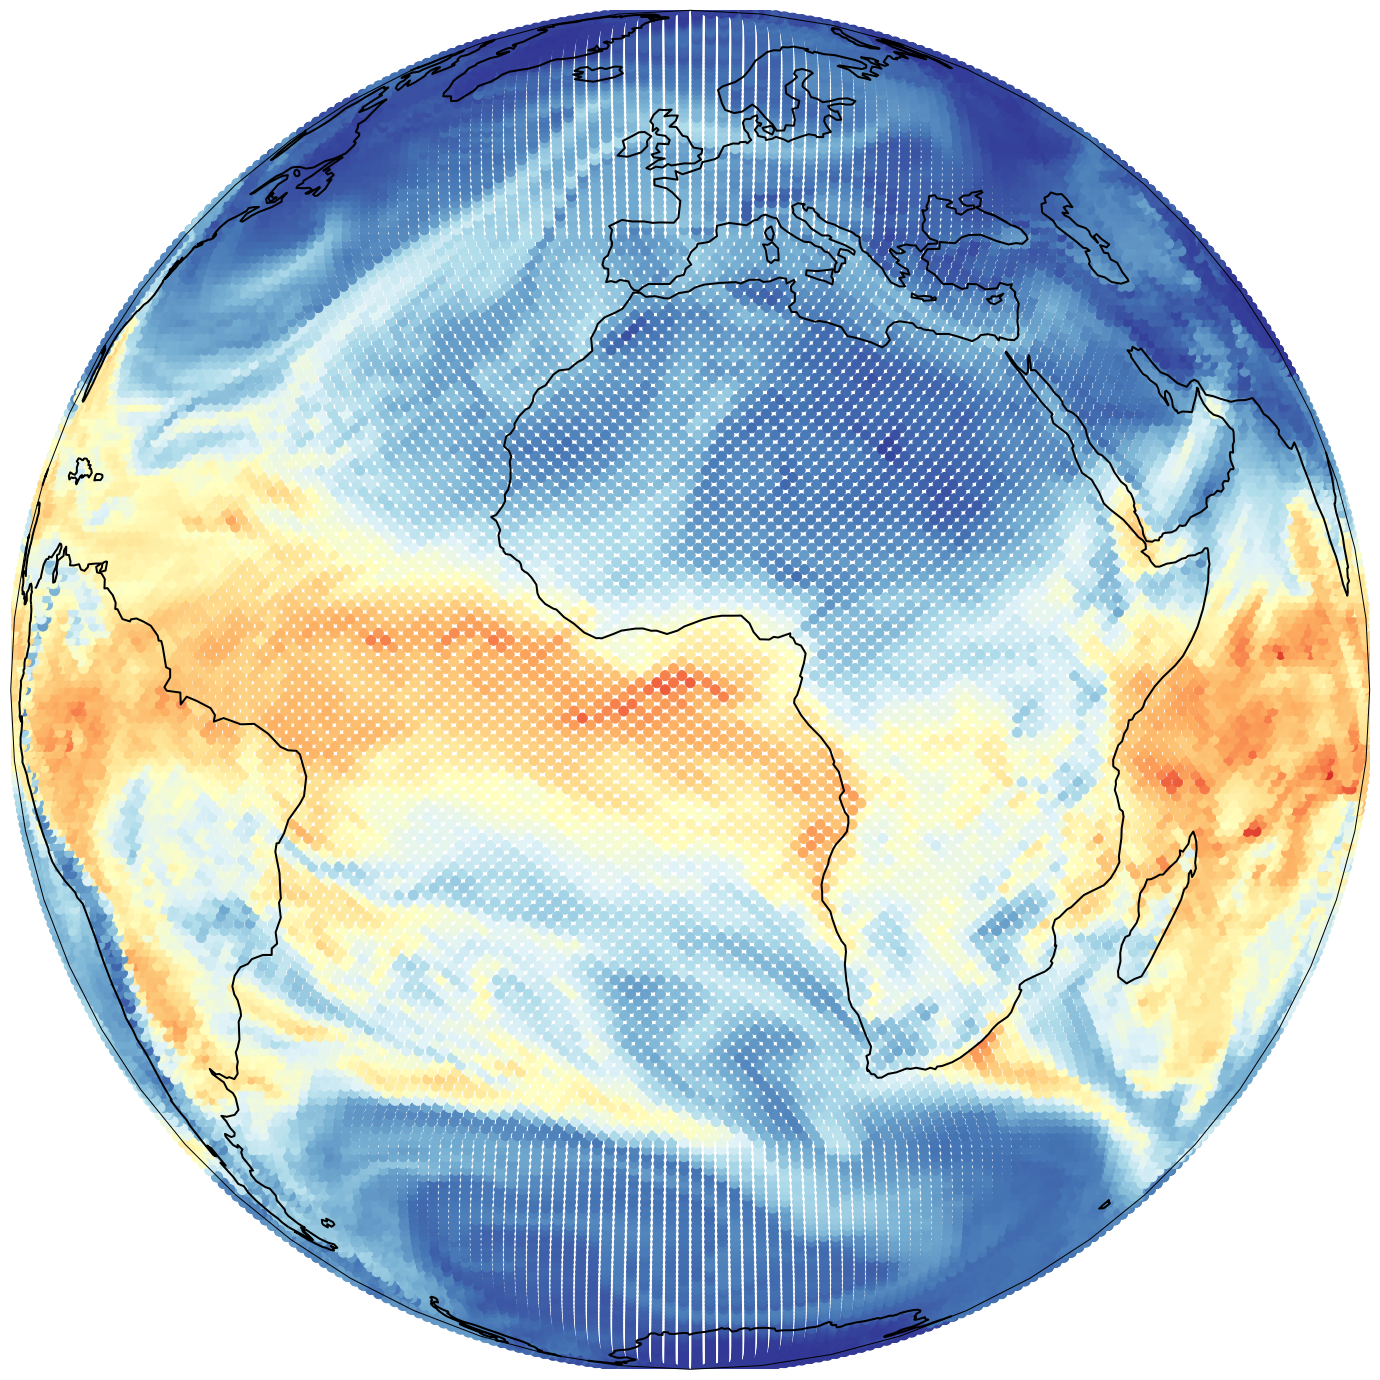

In [43]:
fig = plt.figure(figsize=(25, 25))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(0, 0))
ax.set_global()
ax.coastlines(linewidth=2)

# zmin, zmax = -20, 40

plt.scatter(coords_hp[:,0], coords_hp[:,1], s=100,
            c=map_hp3, cmap=plt.get_cmap('RdYlBu_r'), alpha=1, transform=ccrs.PlateCarree())

In [ ]:
def box_labels(predictions):
    # modify predictions to have bounding box
    return predictions

def iou_score(labels, predictions, nclass):
    iou = []
    for i in range(nclass):
        intersect = ((labels==i) + (predictions==i)).eq(2).sum().item()
        union = ((labels==i) + (predictions==i)).sum()
        iou.append(intersect/union)
    return np.asarray(iou)

# def average_precision():
#     pass

# def accuracy():
#     pass

## data

In [6]:
years = [1979, 1981, 1984, 2005]
path = '../data/ExtremeWeather/EW_{}nside_{}.npz'
Nside = 32
datas = []
labels = []
for year in years:
    datapath = path.format(Nside, year)
    file = np.load(datapath)
    data = file['data']  # N x M x F
    label = file['labels']  # N x M
    datas.append(data)
    labels.append(label)
datas = np.stack(datas)
labels = np.stack(labels)

ValueError: all input arrays must have the same shape

In [61]:
limit=1200
x_train = data[:limit,:,:]
labels_train = labels[:limit,:]
x_val = data[limit:,:,:]
labels_val = labels[limit:,:]

training = LabeledDataset(x_train, labels_train)
validation = LabeledDataset(x_val, labels_val)

## Training

In [56]:
EXP_NAME = 'TestExtremeWeather'

In [94]:
import tensorflow as tf
params = {'nsides': [nside, nside,nside//2,nside//4,nside//8,nside//16,nside//32, nside//32],
          'F': [20, 20, 50, 80, 100, 200, 400],#np.max(labels_train).astype(int)+1],
          'K': [4]*7,
          'batch_norm': [True]*7}
params['dir_name'] = EXP_NAME
params['num_feat_in'] = x_train.shape[-1] # 2*days_pred+3
params['conv'] = 'chebyshev5'
params['pool'] = 'average'
params['activation'] = 'relu'
params['statistics'] = None#'mean'
params['regularization'] = 0
params['dropout'] = 1
params['num_epochs'] = 1000  # Number of passes through the training data.
params['batch_size'] = 32
params['scheduler'] = lambda step: tf.train.exponential_decay(1e-3, step, decay_steps=2000, decay_rate=1)
#params['optimizer'] = lambda lr: tf.train.GradientDescentOptimizer(lr)
params['optimizer'] = lambda lr: tf.train.RMSPropOptimizer(lr, decay=0.9, momentum=0.)
n_evaluations = 1000
params['eval_frequency'] = int(params['num_epochs'] * (training.N) / params['batch_size'] / n_evaluations)
params['M'] = []
params['Fseg'] = np.max(labels_train).astype(int)+1

In [102]:
print([12*nside**2 for nside in params['nsides']])
model = models.deepsphere(**params)

[49152, 49152, 12288, 3072, 768, 192, 48, 48]
NN architecture
  input: M_0 = 49152
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 49152 * 20 / 1 = 983040
    weights: F_0 * F_1 * K_1 = 16 * 20 * 4 = 1280
    biases: F_1 = 20
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 49152 * 20 / 4 = 245760
    weights: F_1 * F_2 * K_2 = 20 * 20 * 4 = 1600
    biases: F_2 = 20
    batch normalization
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 12288 * 50 / 4 = 153600
    weights: F_2 * F_3 * K_3 = 20 * 50 * 4 = 4000
    biases: F_3 = 50
    batch normalization
  layer 4: cgconv4
    representation: M_3 * F_4 / p_4 = 3072 * 80 / 4 = 61440
    weights: F_3 * F_4 * K_4 = 50 * 80 * 4 = 16000
    biases: F_4 = 80
    batch normalization
  layer 5: cgconv5
    representation: M_4 * F_5 / p_5 = 768 * 100 / 4 = 19200
    weights: F_4 * F_5 * K_5 = 80 * 100 * 4 = 32000
    biases: F_5 = 100
    batch normalization
  layer 6: cgconv6
    representation

In [103]:
model.fit(training, validation)

step 37 / 37500 (epoch 0.99 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.68, training loss = 7.05e-01


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 96.19 (12104077 / 12582912), f1 (weighted): 94.33, loss: 2.17e-01
  CPU time: 83s, wall time: 127s, perf_time_load: 1.837s, perf_time: 1.994s
step 74 / 37500 (epoch 1.97 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.83, training loss = 2.00e-01
  validation accuracy: 96.19 (12104077 / 12582912), f1 (weighted): 94.33, loss: 4.28e-01
  CPU time: 158s, wall time: 244s, perf_time_load: 1.699s, perf_time: 1.866s
step 111 / 37500 (epoch 2.96 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.87, training loss = 2.12e-01
  validation accuracy: 96.19 (12104077 / 12582912), f1 (weighted): 94.33, loss: 2.35e-01
  CPU time: 227s, wall time: 356s, perf_time_load: 1.702s, perf_time: 1.854s
step 148 / 37500 (epoch 3.95 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.90, training loss = 1.51e-01
  validation accuracy: 96.19 (12104077 / 12582912), f1 (weighted): 94.33, loss: 2.50e-01
  CPU time: 296s, wall time: 468s, perf_time_load: 1.681s, perf_

  validation accuracy: 96.07 (12088836 / 12582912), f1 (weighted): 94.29, loss: 2.76e-01
  CPU time: 2114s, wall time: 3402s, perf_time_load: 1.689s, perf_time: 1.849s
step 1147 / 37500 (epoch 30.59 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.96, training loss = 9.04e-02
  validation accuracy: 96.19 (12103630 / 12582912), f1 (weighted): 94.33, loss: 2.93e-01
  CPU time: 2184s, wall time: 3515s, perf_time_load: 1.692s, perf_time: 1.846s
step 1184 / 37500 (epoch 31.57 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.96, training loss = 1.40e-01
  validation accuracy: 96.19 (12104077 / 12582912), f1 (weighted): 94.33, loss: 6.30e-01
  CPU time: 2253s, wall time: 3627s, perf_time_load: 1.689s, perf_time: 1.842s
step 1221 / 37500 (epoch 32.56 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.96, training loss = 8.02e-02
  validation accuracy: 81.90 (10305933 / 12582912), f1 (weighted): 86.65, loss: 8.90e-01
  CPU time: 2322s, wall time: 3739s, perf_time_loa

step 2183 / 37500 (epoch 58.21 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.97, training loss = 3.74e-02
  validation accuracy: 95.58 (12027115 / 12582912), f1 (weighted): 94.15, loss: 3.39e-01
  CPU time: 4094s, wall time: 6642s, perf_time_load: 1.697s, perf_time: 1.858s
step 2220 / 37500 (epoch 59.20 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.97, training loss = 3.81e-02
  validation accuracy: 93.08 (11712488 / 12582912), f1 (weighted): 93.05, loss: 4.64e-01
  CPU time: 4163s, wall time: 6756s, perf_time_load: 1.687s, perf_time: 1.817s
step 2257 / 37500 (epoch 60.19 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.97, training loss = 4.07e-02
  validation accuracy: 95.48 (12014130 / 12582912), f1 (weighted): 94.00, loss: 4.56e-01
  CPU time: 4230s, wall time: 6869s, perf_time_load: 1.670s, perf_time: 1.811s
step 2294 / 37500 (epoch 61.17 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.97, training loss = 4.87e-02
  validation accurac

step 3256 / 37500 (epoch 86.83 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.97, training loss = 3.18e-02
  validation accuracy: 94.91 (11942242 / 12582912), f1 (weighted): 93.72, loss: 1.10e+00
  CPU time: 6052s, wall time: 9886s, perf_time_load: 1.659s, perf_time: 1.776s
step 3293 / 37500 (epoch 87.81 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.97, training loss = 2.87e-02
  validation accuracy: 93.73 (11794559 / 12582912), f1 (weighted): 93.40, loss: 5.91e-01
  CPU time: 6117s, wall time: 9998s, perf_time_load: 1.660s, perf_time: 1.775s
step 3330 / 37500 (epoch 88.80 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.97, training loss = 3.02e-02
  validation accuracy: 95.19 (11977851 / 12582912), f1 (weighted): 93.96, loss: 7.15e-01
  CPU time: 6182s, wall time: 10110s, perf_time_load: 1.664s, perf_time: 1.778s
step 3367 / 37500 (epoch 89.79 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.98, training loss = 3.62e-02
  validation accura

  validation accuracy: 94.12 (11843038 / 12582912), f1 (weighted): 93.46, loss: 5.27e-01
  CPU time: 7918s, wall time: 13006s, perf_time_load: 1.692s, perf_time: 1.846s
step 4329 / 37500 (epoch 115.44 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.98, training loss = 2.11e-02
  validation accuracy: 95.10 (11966480 / 12582912), f1 (weighted): 93.93, loss: 4.93e-01
  CPU time: 7986s, wall time: 13117s, perf_time_load: 1.700s, perf_time: 1.861s
step 4366 / 37500 (epoch 116.43 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.98, training loss = 3.49e-02
  validation accuracy: 88.61 (11149376 / 12582912), f1 (weighted): 90.45, loss: 9.98e-01
  CPU time: 8054s, wall time: 13228s, perf_time_load: 1.706s, perf_time: 1.867s
step 4403 / 37500 (epoch 117.41 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.98, training loss = 3.63e-02
  validation accuracy: 91.96 (11571413 / 12582912), f1 (weighted): 92.45, loss: 5.18e-01
  CPU time: 8122s, wall time: 13340s, perf_t

step 5365 / 37500 (epoch 143.07 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.98, training loss = 1.54e-02
  validation accuracy: 69.50 (8744912 / 12582912), f1 (weighted): 79.00, loss: 2.59e+00
  CPU time: 9948s, wall time: 16277s, perf_time_load: 1.685s, perf_time: 1.836s
step 5402 / 37500 (epoch 144.05 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.98, training loss = 1.85e-02
  validation accuracy: 95.00 (11953539 / 12582912), f1 (weighted): 93.86, loss: 5.61e-01
  CPU time: 10017s, wall time: 16389s, perf_time_load: 1.690s, perf_time: 1.849s
step 5439 / 37500 (epoch 145.04 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.98, training loss = 1.35e-02
  validation accuracy: 68.09 (8568047 / 12582912), f1 (weighted): 78.05, loss: 3.14e+00
  CPU time: 10088s, wall time: 16502s, perf_time_load: 1.699s, perf_time: 1.860s
step 5476 / 37500 (epoch 146.03 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.98, training loss = 1.94e-02
  validation 

  validation accuracy: 94.43 (11882184 / 12582912), f1 (weighted): 93.59, loss: 6.11e-01
  CPU time: 11904s, wall time: 19432s, perf_time_load: 1.699s, perf_time: 1.861s
step 6438 / 37500 (epoch 171.68 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.98, training loss = 1.89e-02
  validation accuracy: 95.56 (12024446 / 12582912), f1 (weighted): 94.12, loss: 6.76e-01
  CPU time: 11975s, wall time: 19545s, perf_time_load: 1.688s, perf_time: 1.841s
step 6475 / 37500 (epoch 172.67 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.98, training loss = 3.11e-02
  validation accuracy: 95.75 (12047515 / 12582912), f1 (weighted): 94.30, loss: 5.13e-01
  CPU time: 12045s, wall time: 19658s, perf_time_load: 1.691s, perf_time: 1.852s
step 6512 / 37500 (epoch 173.65 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.98, training loss = 1.95e-02
  validation accuracy: 90.63 (11403816 / 12582912), f1 (weighted): 91.54, loss: 9.03e-01
  CPU time: 12114s, wall time: 19769s, pe

step 7474 / 37500 (epoch 199.31 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.98, training loss = 1.22e-02
  validation accuracy: 83.59 (10517763 / 12582912), f1 (weighted): 87.93, loss: 1.04e+00
  CPU time: 13882s, wall time: 22659s, perf_time_load: 1.688s, perf_time: 1.846s
step 7511 / 37500 (epoch 200.29 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.98, training loss = 1.21e-02
  validation accuracy: 95.00 (11954032 / 12582912), f1 (weighted): 94.34, loss: 4.35e-01
  CPU time: 13950s, wall time: 22770s, perf_time_load: 1.718s, perf_time: 1.878s
step 7548 / 37500 (epoch 201.28 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.98, training loss = 1.33e-02
  validation accuracy: 93.93 (11818745 / 12582912), f1 (weighted): 93.43, loss: 6.76e-01
  CPU time: 14018s, wall time: 22881s, perf_time_load: 1.701s, perf_time: 1.856s
step 7585 / 37500 (epoch 202.27 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.98, training loss = 1.10e-02
  validati

  validation accuracy: 95.62 (12032373 / 12582912), f1 (weighted): 94.25, loss: 6.67e-01
  CPU time: 15787s, wall time: 25769s, perf_time_load: 1.683s, perf_time: 1.837s
step 8547 / 37500 (epoch 227.92 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 2.05e-02
  validation accuracy: 93.99 (11826559 / 12582912), f1 (weighted): 93.54, loss: 5.69e-01
  CPU time: 15855s, wall time: 25881s, perf_time_load: 1.687s, perf_time: 1.840s
step 8584 / 37500 (epoch 228.91 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 1.12e-02
  validation accuracy: 94.86 (11936699 / 12582912), f1 (weighted): 93.86, loss: 6.23e-01
  CPU time: 15923s, wall time: 25992s, perf_time_load: 1.698s, perf_time: 1.861s
step 8621 / 37500 (epoch 229.89 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 2.74e-02
  validation accuracy: 92.17 (11597950 / 12582912), f1 (weighted): 92.54, loss: 9.43e-01
  CPU time: 15992s, wall time: 26104s, pe

step 9583 / 37500 (epoch 255.55 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 9.94e-03
  validation accuracy: 95.36 (11998537 / 12582912), f1 (weighted): 94.02, loss: 8.27e-01
  CPU time: 17762s, wall time: 28991s, perf_time_load: 1.697s, perf_time: 1.851s
step 9620 / 37500 (epoch 256.53 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 1.07e-02
  validation accuracy: 94.30 (11865467 / 12582912), f1 (weighted): 93.53, loss: 9.87e-01
  CPU time: 17829s, wall time: 29101s, perf_time_load: 1.702s, perf_time: 1.866s
step 9657 / 37500 (epoch 257.52 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 1.37e-02
  validation accuracy: 94.60 (11904007 / 12582912), f1 (weighted): 93.62, loss: 1.08e+00
  CPU time: 17897s, wall time: 29212s, perf_time_load: 1.670s, perf_time: 1.818s
step 9694 / 37500 (epoch 258.51 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 1.03e-02
  validati

  validation accuracy: 95.98 (12076553 / 12582912), f1 (weighted): 94.48, loss: 4.20e-01
  CPU time: 19660s, wall time: 32120s, perf_time_load: 1.684s, perf_time: 1.810s
step 10656 / 37500 (epoch 284.16 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 1.25e-02
  validation accuracy: 79.84 (10046193 / 12582912), f1 (weighted): 85.70, loss: 1.44e+00
  CPU time: 19726s, wall time: 32230s, perf_time_load: 1.691s, perf_time: 1.845s
step 10693 / 37500 (epoch 285.15 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 1.39e-02
  validation accuracy: 83.38 (10491195 / 12582912), f1 (weighted): 87.65, loss: 1.40e+00
  CPU time: 19795s, wall time: 32341s, perf_time_load: 1.681s, perf_time: 1.832s
step 10730 / 37500 (epoch 286.13 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 9.01e-03
  validation accuracy: 90.12 (11339899 / 12582912), f1 (weighted): 91.42, loss: 7.30e-01
  CPU time: 19863s, wall time: 32452s,

step 11692 / 37500 (epoch 311.79 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 1.25e-02
  validation accuracy: 95.00 (11953702 / 12582912), f1 (weighted): 93.93, loss: 5.70e-01
  CPU time: 21633s, wall time: 35343s, perf_time_load: 1.709s, perf_time: 1.871s
step 11729 / 37500 (epoch 312.77 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 1.10e-02
  validation accuracy: 94.75 (11921953 / 12582912), f1 (weighted): 93.84, loss: 5.99e-01
  CPU time: 21701s, wall time: 35454s, perf_time_load: 1.697s, perf_time: 1.850s
step 11766 / 37500 (epoch 313.76 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 1.37e-02
  validation accuracy: 95.92 (12069344 / 12582912), f1 (weighted): 94.44, loss: 5.23e-01
  CPU time: 21768s, wall time: 35565s, perf_time_load: 1.723s, perf_time: 1.884s
step 11803 / 37500 (epoch 314.75 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 1.21e-02
  vali

  validation accuracy: 92.32 (11616037 / 12582912), f1 (weighted): 92.74, loss: 6.61e-01
  CPU time: 23533s, wall time: 38450s, perf_time_load: 1.689s, perf_time: 1.849s
step 12765 / 37500 (epoch 340.40 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 1.16e-02
  validation accuracy: 94.17 (11849582 / 12582912), f1 (weighted): 93.86, loss: 5.47e-01
  CPU time: 23601s, wall time: 38561s, perf_time_load: 1.687s, perf_time: 1.839s
step 12802 / 37500 (epoch 341.39 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 1.21e-02
  validation accuracy: 92.98 (11700123 / 12582912), f1 (weighted): 92.98, loss: 7.22e-01
  CPU time: 23669s, wall time: 38672s, perf_time_load: 1.704s, perf_time: 1.849s
step 12839 / 37500 (epoch 342.37 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 1.08e-02
  validation accuracy: 81.51 (10256577 / 12582912), f1 (weighted): 86.65, loss: 1.47e+00
  CPU time: 23737s, wall time: 38784s,

step 13801 / 37500 (epoch 368.03 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 8.74e-03
  validation accuracy: 94.14 (11845386 / 12582912), f1 (weighted): 93.44, loss: 6.30e-01
  CPU time: 25506s, wall time: 41672s, perf_time_load: 1.682s, perf_time: 1.832s
step 13838 / 37500 (epoch 369.01 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 1.19e-02
  validation accuracy: 95.50 (12017299 / 12582912), f1 (weighted): 94.11, loss: 6.69e-01
  CPU time: 25578s, wall time: 41788s, perf_time_load: 1.697s, perf_time: 1.855s
step 13875 / 37500 (epoch 370.00 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 2.13e-02
  validation accuracy: 95.57 (12025370 / 12582912), f1 (weighted): 94.17, loss: 8.64e-01
  CPU time: 25645s, wall time: 41898s, perf_time_load: 1.696s, perf_time: 1.849s
step 13912 / 37500 (epoch 370.99 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 9.42e-03
  vali

  validation accuracy: 92.75 (11671048 / 12582912), f1 (weighted): 92.92, loss: 7.95e-01
  CPU time: 27406s, wall time: 44797s, perf_time_load: 1.679s, perf_time: 1.818s
step 14874 / 37500 (epoch 396.64 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 9.59e-03
  validation accuracy: 95.29 (11990412 / 12582912), f1 (weighted): 94.25, loss: 6.63e-01
  CPU time: 27478s, wall time: 44912s, perf_time_load: 1.681s, perf_time: 1.809s
step 14911 / 37500 (epoch 397.63 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 1.24e-02
  validation accuracy: 94.83 (11932137 / 12582912), f1 (weighted): 93.93, loss: 6.61e-01
  CPU time: 27547s, wall time: 45026s, perf_time_load: 1.676s, perf_time: 1.813s
step 14948 / 37500 (epoch 398.61 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 9.03e-03
  validation accuracy: 92.69 (11663598 / 12582912), f1 (weighted): 92.85, loss: 7.66e-01
  CPU time: 27617s, wall time: 45141s,

step 15910 / 37500 (epoch 424.27 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 6.36e-03
  validation accuracy: 94.27 (11861431 / 12582912), f1 (weighted): 93.85, loss: 5.95e-01
  CPU time: 29377s, wall time: 48060s, perf_time_load: 1.684s, perf_time: 1.838s
step 15947 / 37500 (epoch 425.25 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 1.01e-02
  validation accuracy: 95.36 (11998813 / 12582912), f1 (weighted): 94.07, loss: 7.36e-01
  CPU time: 29445s, wall time: 48171s, perf_time_load: 1.684s, perf_time: 1.840s
step 15984 / 37500 (epoch 426.24 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 6.50e-03
  validation accuracy: 89.64 (11278772 / 12582912), f1 (weighted): 91.19, loss: 8.94e-01
  CPU time: 29513s, wall time: 48282s, perf_time_load: 1.698s, perf_time: 1.861s
step 16021 / 37500 (epoch 427.23 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 6.55e-03
  vali

  validation accuracy: 95.11 (11967057 / 12582912), f1 (weighted): 93.91, loss: 7.93e-01
  CPU time: 31277s, wall time: 51165s, perf_time_load: 1.674s, perf_time: 1.828s
step 16983 / 37500 (epoch 452.88 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 7.18e-03
  validation accuracy: 93.77 (11799230 / 12582912), f1 (weighted): 93.43, loss: 5.96e-01
  CPU time: 31345s, wall time: 51277s, perf_time_load: 1.689s, perf_time: 1.837s
step 17020 / 37500 (epoch 453.87 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 8.07e-03
  validation accuracy: 94.23 (11857474 / 12582912), f1 (weighted): 93.63, loss: 5.26e-01
  CPU time: 31413s, wall time: 51387s, perf_time_load: 1.688s, perf_time: 1.841s
step 17057 / 37500 (epoch 454.85 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 8.51e-03
  validation accuracy: 94.63 (11907475 / 12582912), f1 (weighted): 93.81, loss: 6.25e-01
  CPU time: 31482s, wall time: 51499s,

step 18019 / 37500 (epoch 480.51 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 1.08e-02
  validation accuracy: 90.83 (11429585 / 12582912), f1 (weighted): 91.79, loss: 1.49e+00
  CPU time: 33258s, wall time: 54392s, perf_time_load: 1.695s, perf_time: 1.853s
step 18056 / 37500 (epoch 481.49 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 8.94e-03
  validation accuracy: 93.50 (11764684 / 12582912), f1 (weighted): 93.28, loss: 7.67e-01
  CPU time: 33326s, wall time: 54504s, perf_time_load: 1.686s, perf_time: 1.844s
step 18093 / 37500 (epoch 482.48 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 9.14e-03
  validation accuracy: 93.87 (11811001 / 12582912), f1 (weighted): 93.49, loss: 6.94e-01
  CPU time: 33394s, wall time: 54615s, perf_time_load: 1.697s, perf_time: 1.854s
step 18130 / 37500 (epoch 483.47 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 7.89e-03
  vali

  validation accuracy: 93.94 (11820623 / 12582912), f1 (weighted): 93.36, loss: 9.69e-01
  CPU time: 35150s, wall time: 57490s, perf_time_load: 1.682s, perf_time: 1.828s
step 19092 / 37500 (epoch 509.12 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 6.19e-03
  validation accuracy: 94.21 (11853857 / 12582912), f1 (weighted): 93.46, loss: 8.28e-01
  CPU time: 35218s, wall time: 57600s, perf_time_load: 1.681s, perf_time: 1.826s
step 19129 / 37500 (epoch 510.11 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 1.16e-02
  validation accuracy: 94.95 (11947432 / 12582912), f1 (weighted): 93.87, loss: 1.09e+00
  CPU time: 35285s, wall time: 57711s, perf_time_load: 1.686s, perf_time: 1.835s
step 19166 / 37500 (epoch 511.09 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 6.46e-03
  validation accuracy: 95.64 (12034321 / 12582912), f1 (weighted): 94.37, loss: 6.68e-01
  CPU time: 35353s, wall time: 57822s,

step 20128 / 37500 (epoch 536.75 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 9.00e-03
  validation accuracy: 95.16 (11973704 / 12582912), f1 (weighted): 94.04, loss: 7.93e-01
  CPU time: 37132s, wall time: 60719s, perf_time_load: 1.699s, perf_time: 1.862s
step 20165 / 37500 (epoch 537.73 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 7.26e-03
  validation accuracy: 95.22 (11981380 / 12582912), f1 (weighted): 94.24, loss: 5.89e-01
  CPU time: 37200s, wall time: 60831s, perf_time_load: 1.686s, perf_time: 1.847s
step 20202 / 37500 (epoch 538.72 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 6.72e-03
  validation accuracy: 93.79 (11801214 / 12582912), f1 (weighted): 93.51, loss: 8.23e-01
  CPU time: 37269s, wall time: 60942s, perf_time_load: 1.692s, perf_time: 1.848s
step 20239 / 37500 (epoch 539.71 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 6.91e-03
  vali

  validation accuracy: 93.95 (11821805 / 12582912), f1 (weighted): 93.74, loss: 6.66e-01
  CPU time: 39044s, wall time: 63836s, perf_time_load: 1.696s, perf_time: 1.847s
step 21201 / 37500 (epoch 565.36 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 7.89e-03
  validation accuracy: 91.97 (11572846 / 12582912), f1 (weighted): 92.51, loss: 9.45e-01
  CPU time: 39113s, wall time: 63947s, perf_time_load: 1.688s, perf_time: 1.842s
step 21238 / 37500 (epoch 566.35 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 7.64e-03
  validation accuracy: 91.36 (11495234 / 12582912), f1 (weighted): 92.24, loss: 9.78e-01
  CPU time: 39180s, wall time: 64058s, perf_time_load: 1.694s, perf_time: 1.847s
step 21275 / 37500 (epoch 567.33 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 7.11e-03
  validation accuracy: 94.89 (11940046 / 12582912), f1 (weighted): 94.06, loss: 6.46e-01
  CPU time: 39248s, wall time: 64169s,

step 22237 / 37500 (epoch 592.99 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 6.84e-03
  validation accuracy: 93.51 (11766894 / 12582912), f1 (weighted): 93.27, loss: 6.83e-01
  CPU time: 41010s, wall time: 67051s, perf_time_load: 1.698s, perf_time: 1.861s
step 22274 / 37500 (epoch 593.97 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 9.62e-03
  validation accuracy: 94.64 (11907948 / 12582912), f1 (weighted): 93.66, loss: 1.38e+00
  CPU time: 41078s, wall time: 67162s, perf_time_load: 1.698s, perf_time: 1.856s
step 22311 / 37500 (epoch 594.96 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 7.52e-03
  validation accuracy: 95.38 (12001629 / 12582912), f1 (weighted): 94.19, loss: 6.05e-01
  CPU time: 41146s, wall time: 67273s, perf_time_load: 1.695s, perf_time: 1.849s
step 22348 / 37500 (epoch 595.95 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 7.49e-03
  vali

  validation accuracy: 95.25 (11985789 / 12582912), f1 (weighted): 94.01, loss: 1.10e+00
  CPU time: 42917s, wall time: 70162s, perf_time_load: 1.690s, perf_time: 1.846s
step 23310 / 37500 (epoch 621.60 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 6.36e-03
  validation accuracy: 94.97 (11950416 / 12582912), f1 (weighted): 94.09, loss: 7.46e-01
  CPU time: 42985s, wall time: 70273s, perf_time_load: 1.700s, perf_time: 1.853s
step 23347 / 37500 (epoch 622.59 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 6.61e-03
  validation accuracy: 92.54 (11643749 / 12582912), f1 (weighted): 92.76, loss: 1.00e+00
  CPU time: 43054s, wall time: 70384s, perf_time_load: 1.691s, perf_time: 1.846s
step 23384 / 37500 (epoch 623.57 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 6.81e-03
  validation accuracy: 95.22 (11981263 / 12582912), f1 (weighted): 94.04, loss: 1.06e+00
  CPU time: 43121s, wall time: 70495s,

step 24346 / 37500 (epoch 649.23 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 5.85e-03
  validation accuracy: 94.91 (11942980 / 12582912), f1 (weighted): 93.91, loss: 8.53e-01
  CPU time: 44887s, wall time: 73382s, perf_time_load: 1.689s, perf_time: 1.846s
step 24383 / 37500 (epoch 650.21 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 5.36e-03
  validation accuracy: 94.86 (11936114 / 12582912), f1 (weighted): 93.92, loss: 7.00e-01
  CPU time: 44955s, wall time: 73493s, perf_time_load: 1.680s, perf_time: 1.837s
step 24420 / 37500 (epoch 651.20 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 6.24e-03
  validation accuracy: 93.51 (11766419 / 12582912), f1 (weighted): 93.10, loss: 9.51e-01
  CPU time: 45023s, wall time: 73603s, perf_time_load: 1.695s, perf_time: 1.849s
step 24457 / 37500 (epoch 652.19 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 4.69e-03
  vali

  validation accuracy: 95.58 (12026140 / 12582912), f1 (weighted): 94.51, loss: 5.62e-01
  CPU time: 46785s, wall time: 76488s, perf_time_load: 1.691s, perf_time: 1.842s
step 25419 / 37500 (epoch 677.84 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 6.93e-03
  validation accuracy: 95.54 (12021787 / 12582912), f1 (weighted): 94.32, loss: 8.52e-01
  CPU time: 46853s, wall time: 76599s, perf_time_load: 1.720s, perf_time: 1.876s
step 25456 / 37500 (epoch 678.83 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 7.53e-03
  validation accuracy: 89.23 (11227603 / 12582912), f1 (weighted): 91.03, loss: 1.34e+00
  CPU time: 46920s, wall time: 76709s, perf_time_load: 1.687s, perf_time: 1.841s
step 25493 / 37500 (epoch 679.81 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 5.91e-03
  validation accuracy: 94.58 (11900536 / 12582912), f1 (weighted): 93.81, loss: 7.05e-01
  CPU time: 46989s, wall time: 76821s,

step 26455 / 37500 (epoch 705.47 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 5.51e-03
  validation accuracy: 93.39 (11751807 / 12582912), f1 (weighted): 93.24, loss: 9.55e-01
  CPU time: 48752s, wall time: 79703s, perf_time_load: 1.687s, perf_time: 1.844s
step 26492 / 37500 (epoch 706.45 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 6.59e-03
  validation accuracy: 82.26 (10350693 / 12582912), f1 (weighted): 87.14, loss: 1.98e+00
  CPU time: 48820s, wall time: 79814s, perf_time_load: 1.687s, perf_time: 1.844s
step 26529 / 37500 (epoch 707.44 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 4.76e-02
  validation accuracy: 95.49 (12015739 / 12582912), f1 (weighted): 94.04, loss: 1.52e+00
  CPU time: 48888s, wall time: 79925s, perf_time_load: 1.701s, perf_time: 1.858s
step 26566 / 37500 (epoch 708.43 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 5.65e-03
  vali

  validation accuracy: 95.45 (12010895 / 12582912), f1 (weighted): 94.22, loss: 8.16e-01
  CPU time: 50649s, wall time: 82806s, perf_time_load: 1.680s, perf_time: 1.829s
step 27528 / 37500 (epoch 734.08 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 5.48e-03
  validation accuracy: 95.61 (12030482 / 12582912), f1 (weighted): 94.29, loss: 6.62e-01
  CPU time: 50715s, wall time: 82915s, perf_time_load: 1.675s, perf_time: 1.821s
step 27565 / 37500 (epoch 735.07 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 5.47e-03
  validation accuracy: 94.85 (11934493 / 12582912), f1 (weighted): 93.79, loss: 8.35e-01
  CPU time: 50781s, wall time: 83025s, perf_time_load: 1.687s, perf_time: 1.834s
step 27602 / 37500 (epoch 736.05 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 4.73e-03
  validation accuracy: 92.86 (11683974 / 12582912), f1 (weighted): 93.08, loss: 7.74e-01
  CPU time: 50848s, wall time: 83135s,

KeyboardInterrupt: 

In [105]:
x_train.shape

(1200, 49152, 16)

In [106]:
predictions = model.predict(x_train)

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/TestExtremeWeather/model-28268


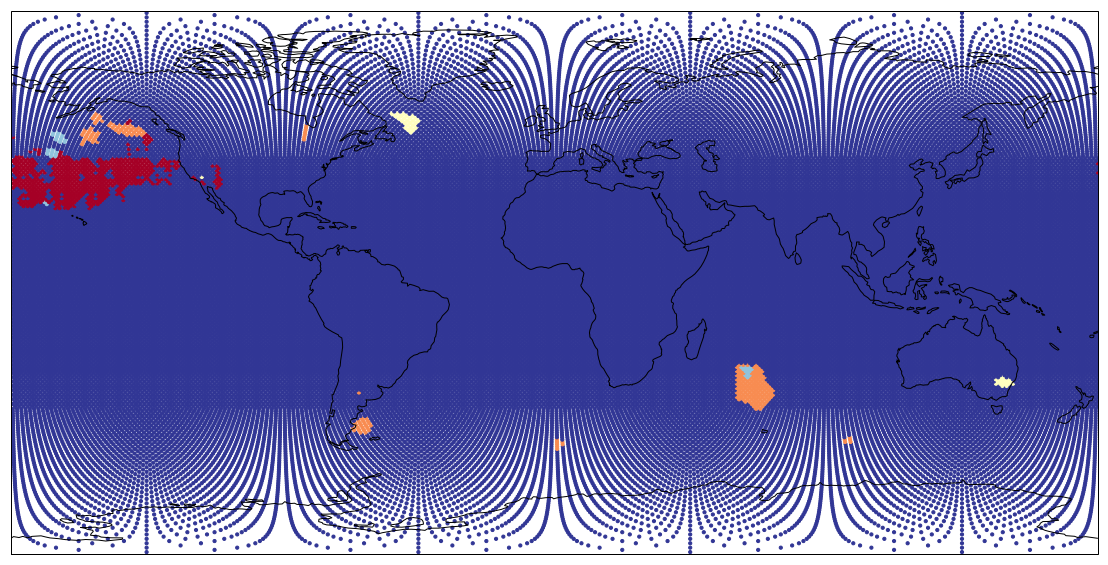

In [107]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.scatter(coords_hp[:,0], coords_hp[:,1], s=10,
            c=predictions[0,:], cmap=plt.get_cmap('RdYlBu_r'), alpha=1)

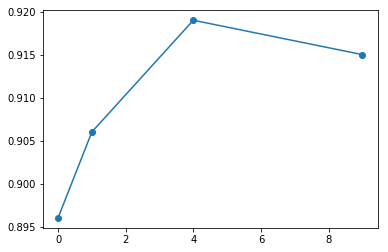

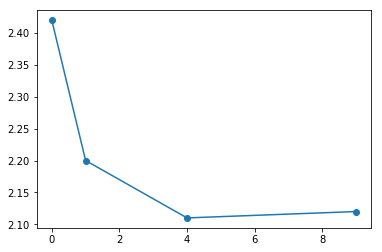

In [110]:
K = [0, 1, 4, 9]
R2 = [0.896, 0.906, 0.919, 0.915]
MAE = [2.42, 2.2, 2.11, 2.12]
plt.plot(K, R2, 'o-')
plt.figure()
plt.plot(K, MAE,'o-')

In [5]:
pathfig = "./figures/"

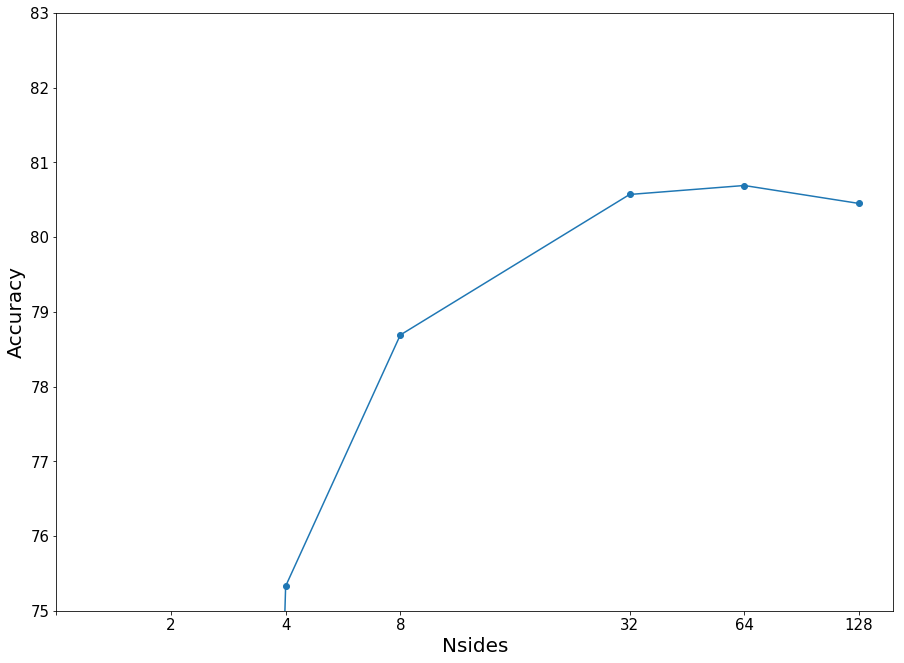

In [6]:
Nside = [2, 4, 8, 32, 64, 128]
npix = [12*nside**2 for nside in Nside]
acc = [23.22, 75.33, 78.69, 80.57, 80.69, 80.45]#[23.22, 78.69, 80.57, 80.69, 79.45]
fig = plt.figure(figsize=(15,11))
ax = fig.add_subplot(111)
ax.plot(np.log(Nside)/np.log(2), acc, 'o-')
plt.ylim([75, 83])
plt.xlabel('Nsides', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.xticks(np.log([1]+Nside)/np.log(2), ['']+Nside, fontsize=15)
plt.yticks(fontsize=15)
plt.savefig(pathfig+"density_plot.png", bboxes_inches='tight')